## Kaggle Backpack Prediction Challenge

In [1]:
#Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load data
data_path = os.path.join(os.getcwd(),'backpack_data')
df_train = pd.read_csv(os.path.join(data_path,'train.csv'))
x_train = df_train.drop(columns=["Price","id"])
y_train = df_train["Price"]
df_test = pd.read_csv(os.path.join(data_path,'test.csv'))

### EDA

In [3]:
# summarytools EDA
from summarytools import dfSummary
dfSummary(df_train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id[int64],Mean (sd) : 149999.5 (86602.7)min < med < max:0.0 < 149999.5 < 299999.0IQR (CV) : 149999.5 (1.7),"300,000 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAAA30lEQVR4nO3UMQoCMRBAURXLqbOFjRfxEJ5gzpYTeArvsY2FqdOvrQgLaVbB/1+ZDGHgQ/bLsuz0/w6/XkDfcVy7KKVcI2IaeaT3fo6I2dnx2Y33eLbWbu9nq6EjYsrMx8jDtdZLZt6dHZ/deI/T55lfN4ShIQwNYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBrC0BCGhjA0hKEhDA1haAhDQxgawtAQhoYwNIShIQwNYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBrC0BCGhjA0hKEhDA1haAhDQxga4gWhg1ey46OS8wAAAABJRU5ErkJggg=="">",0(0.0%)
2,Brand[object],1. Adidas2. Under Armour3. Nike4. Puma5. Jansport6. nan,"60,077 (20.0%)59,992 (20.0%)57,336 (19.1%)56,814 (18.9%)56,076 (18.7%)9,705 (3.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAG8AAABhCAYAAADYz/8QAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABU0lEQVR4nO3ZsWnDUBhG0Si4fK1w4ak8gWbTBJkqRVSrV8oQ3AXZ4cI5AwjBha94/3QcxxtN7//9A/ydeGHihU3zPN/HGNezP7zv+9e2bR9nf5cflzHGdVmWz7M/vK7r7exv8pvZDBMvTLww8cLECxMvTLww8cLECxMvzNtm2OQY22U2w8xmmJNQmNkMEy9MvDDxwsQLEy9MvDDxwsQLEy/M22aYk1CY2Qx7ymyazNd4yknIOeg1zGaYeGHihYkXJl6YeGHihYkXJl6YeGHihXmYDnPPCzObYWYzzD0vzGyGiRcmXph4YeKFiRcmXph4YeKFiRfmbTPMSSjMbIaZzTAnoTCzGSZemHhh4oWJFyZemHhh4oWJFyZemLfNMCehMLMZ9jCbJq/j4STknNNhNsPECxMvTLww8cLECxMvTLww8cLECxMvzMN0mHtemNkMEy/sG67UjuV5wmGzAAAAAElFTkSuQmCC"">","9,705(3.2%)"
3,Material[object],1. Polyester2. Leather3. Nylon4. Canvas5. nan,"79,630 (26.5%)73,416 (24.5%)70,603 (23.5%)68,004 (22.7%)8,347 (2.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAG8AAABRCAYAAADctfi9AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABN0lEQVR4nO3ZsW2DUBhG0RClpEUuPFUmYDYmyFQpQk1ParcRftG1zlkApCt9xfun8zzfaHr/7x/g78QLm5Zl+Zzn+Tb6w8dx/Oz7/jX6u6/kY57n27qu36M/vG3bffQ3X43ZDBMvTLww8cLECxMvTLww8cLECxMvTLwwD9Nhk2Nsl9kMGzqbpvJaQ+95bnjXMpth4oWJFyZemHhh4oWJFyZemHhh4oV52wxzEgozm2HDZtNkXm/YScg56HpmM0y8MPHCxAsTL0y8MPHCxAsTL0y8MG+bYU5CYWYzbMhsmsznGHIScg56DrMZJl6YeGHihYkXJl6YeGHihYkXJl6YeGEepsPc88LMZtjDbJq3lod7nrtbi9kMEy9MvDDxwsQLEy9MvDDxwsQLEy/M22aYk1CY2QwTL+wXP+t3lOnE4IoAAAAASUVORK5CYII="">","8,347(2.8%)"
4,Size[object],1. Medium2. Large3. Small4. nan,"101,906 (34.0%)98,643 (32.9%)92,856 (31.0%)6,595 (2.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAG8AAABBCAYAAADfY/omAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABEklEQVR4nO3ZoW3DUBRA0ToqNLUCMlUn8GyeoFMV1Dg8RS0Ickr8r3TOBE+60rP13/R4PN5oupw9AP8nXti0LMvHPM/Xswd5dr/fv/d9/zx7jpG9z/N8Xdf16+xBnm3bdjt7htFZm2HihYkXJl6YeGHihYkXJl6YeGHihXnbDJvc87qszbAh16aVecyQJyHnoGOszTDxwsQLEy9MvDDxwsQLEy9MvDDxwsQL8zAd5p4XZm2GDbU2rcvXDHXPc8d7jbUZJl6YeGHihYkXJl6YeGHihYkXJl6Yt80wJ6EwazNMvLC/b57vTc/l9543yk8Lx1mbYeKFiRcmXph4YeKFiRcmXph4YeKFedsMc88LszbDfgDw1l5+gJxzMwAAAABJRU5ErkJggg=="">","6,595(2.2%)"
5,Compartments[float64],1. 1.02. 4.03. 2.04. 3.05. 7.06. 9.07. 5.08. 10.09. 8.010. 6.0,"31,568 (10.5%)31,498 (10.5%)30,595 (10.2%)30,293 (10.1%)30,158 (10.1%)29,965 (10.0%)29,959 (10.0%)29,815 (9.9%)28,909 (9.6%)27,240 (9.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAG8AAACjCAYAAACE70CvAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAAB9klEQVR4nO3asWnDUBhG0SikfK1w4akygWfTBJkqRVSrV1Z4Dpjowjm9QXDhK97v5TzPN5re//sD+DvxwsQLEy9MvDDxwpZ1XT/HGLfZHxzH8bPv+9crP4o5H2OM2+Px+J79wbZt91d+EPPMZph4YeKFiRcmXph4YeKFiRcmXph4Yd42wxb/Yekym2FmM8xJKMxshokXJl6YeGHihYkXJl6YeGHihYkXJl6Yh+kw97wwsxn21GyazGt56p7nlnctZjNMvDDxwsQLEy9MvDDxwsQLEy9MvDBvm2FOQmFmM8xshjkJhZnNMPHCxAsTL0y8MPHCxAsTL0y8MPHCvG2GOQmFmc0wsxnmJBRmNsPECxMvTLww8cLECxMvTLww8cLEC/O2GeYkFGY2w8xmmJNQmNkMEy9MvDDxwsQLEy9MvDDxwsQLEy/

In [4]:
# ydata_profiling EDA
from ydata_profiling import ProfileReport
profile = ProfileReport(df_train)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Missing values
print()
row_missing_count = df_train.isna().sum(axis=1)
row_missing_prop = row_missing_count.value_counts()/len(df_train)
print("Number of missing values by row:\n"+str(row_missing_prop))
col_missing_prop = df_train.isna().sum()/len(df_train)
print("\nProportion of missing values by column:\n"+str(col_missing_prop))


Number of missing values by row:
0    0.822287
1    0.165853
2    0.010877
3    0.000877
4    0.000107
dtype: float64

Proportion of missing values by column:
id                      0.000000
Brand                   0.032350
Material                0.027823
Size                    0.021983
Compartments            0.000000
Laptop Compartment      0.024813
Waterproof              0.023500
Style                   0.026567
Color                   0.033167
Weight Capacity (kg)    0.000460
Price                   0.000000
dtype: float64


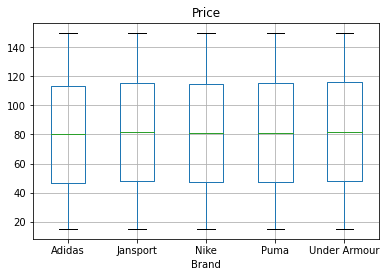

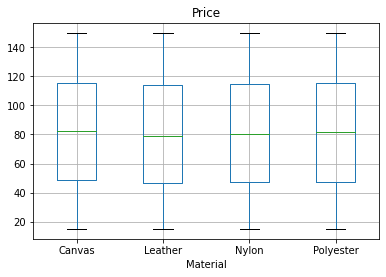

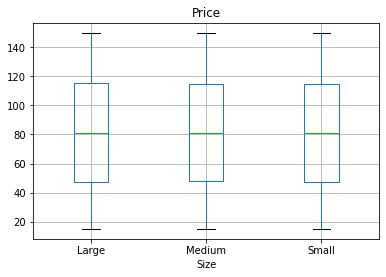

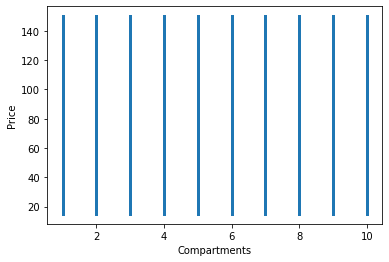

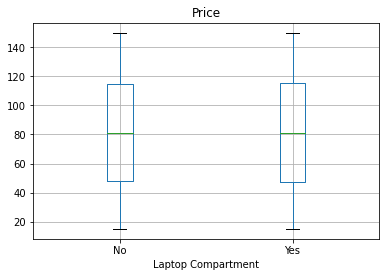

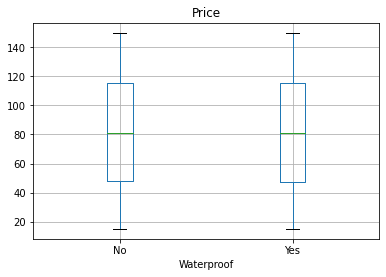

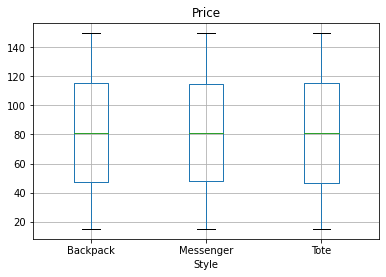

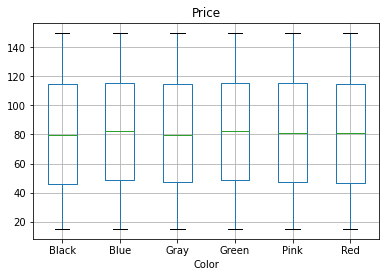

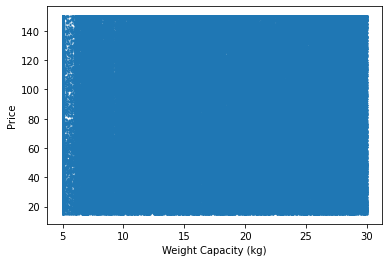

In [6]:
# 2D analysis
for col in x_train.columns:
    # Skip ID
    if col == "id":
        continue
    # Numerical features (Numerical x Numerical)
    if np.issubdtype(df_train[col].dtype, np.number):
        df_train.plot.scatter(x=col, y='Price', s=1)
    # Categorical features (Categorical x Numerical)
    else:
        df_train.boxplot(column='Price', by=col)
    plt.suptitle('')
    # Categorical x Categorical
        #ct = pd.crosstab(df_train['Brand'], df_train[col])
        #display(ct.style.background_gradient(cmap="Blues"))

**EDA Results**
- ID - `id`
    - 300,000 values
- Y/Target - `Price`
    - Ranging from $15 to $150, median≈mean≈$81\
    *Insight: Regression task (e.g. linear regression, KNN regression, decision trees)*
- X - Features
    - Categorical - 5
        - `Brand`, `Material`, `Size`, `Style`, `Color`
            - Low distinct value counts\
            *Insight: Feasible to one-hot encode (4)*
            - Only `Size` is ordinal\
            *Insight: Can ordinal encode (1)*
    - Numerical - 2
        - `Compartments`, `Weight Capacity (kg)`
            - Largely uniformly distributed
            - Largely different scales\
            *Insight: Normalization required (2)*
    - Boolean - 2
        - `Laptop Compartment`, `Waterproof`\
            *Insight: One-hot encoding (4+2=6)*
- Missing Values - 2-3% accross all categorical features (as `nan`), 0.04% missing value from `Weight Capacity (kg)` as `np.nan`\
*Insight: Need to impute (8)*
- Correlation - Price has highest correlation with Weight Capacity at 0.017. Other features are around 0.01-0.017\
*Insight: No single feature has a big effect on price (0.017 is very low). Perhaps a combination of features is required to determine price*

### Feature Engineering

In [7]:
# Create pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Helper function to prefix column names after transformation
def prefixed_columns(prefix, columns):
    arr = []
    for col in columns:
        arr.append(prefix+"__"+col)
    return arr

# Imputation
imp = ColumnTransformer([("cat_imputer", SimpleImputer(missing_values=np.nan, strategy="most_frequent"), ["Brand", "Material", "Size", "Style", "Color", "Laptop Compartment", "Waterproof"]),
                        ("num_imputer", SimpleImputer(missing_values=np.nan, strategy="mean"), ["Weight Capacity (kg)"]),
                        #("ordinal_encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan, categories=[["Small", "Medium", "Large"]]), ["Size"])
                        ],remainder="passthrough",)

# Encoding
enc = ColumnTransformer([("ordinal_encode", OrdinalEncoder(categories=[["Small", "Medium", "Large"]]), prefixed_columns("cat_imputer", ["Size"])),
                        ("onehot_encode", OneHotEncoder(sparse_output=False), prefixed_columns("cat_imputer", ["Brand", "Material", "Style", "Color", "Laptop Compartment", "Waterproof"]))
                        ],remainder="passthrough",)

# Pipeline
pipe = make_pipeline(imp, enc)
pipe.set_output(transform="pandas")

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Brand', 'Material', 'Size',
                                                   'Style', 'Color',
                                                   'Laptop Compartment',
                                                   'Waterproof']),
                                                 ('num_imputer',
                                                  SimpleImputer(),
                                                  ['Weight Capacity (kg)'])])),
                ('columntransformer-2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encode',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'Large']]),
                                                  ['cat_imputer__Size']),
                                                 ('onehot_encode',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['cat_imputer__Brand',
                                                   'cat_imputer__Material',
                                                   'cat_imputer__Style',
                                                   'cat_imputer__Color',
                                                   'cat_imputer__Laptop '
                                                   'Compartment',
                                                   'cat_imputer__Waterproof'])]))])

In [8]:
# Fit and transform
pipe.fit(x_train)
x_train = pipe.transform(x_train)
dfSummary(x_train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ordinal_encode__cat_imputer__Size[float64],1. 1.02. 2.03. 0.0,"108,501 (36.2%)98,643 (32.9%)92,856 (31.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAG8AAAAwCAYAAAAfHSRCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAAA2klEQVR4nO3ZsQ0CMQxAUYIo3UZXMBUTZLZMwFQUXJ0+THDSHU38pf8msPQlF3aZc97EVGqtr4jYVg9yZIzx3ff9vXqOjB4RsbXWPqsHOdJ7f66eIav76gH0P+OBGQ/MeGDGAzMemPHAjAdmPDDjgRkPzMM0WPElxOXaBEu5Nl2V56T85/nDO8e1CWY8MOOBGQ/MeGDGAzMemPHAjAdmPDDjgXmYBvOfB+baBEu1Nl2X16T65/nHu8a1CWY8MOOBGQ/MeGDGAzMemPHAjAdmPDDjgXmYBvOfB/YDGkZI8EZA1ecAAAAASUVORK5CYII="">",0(0.0%)
2,onehot_encode__cat_imputer__Brand_Adidas[float64],1. 0.02. 1.0,"230,218 (76.7%)69,782 (23.3%)",,0(0.0%)
3,onehot_encode__cat_imputer__Brand_Jansport[float64],1. 0.02. 1.0,"243,924 (81.3%)56,076 (18.7%)",,0(0.0%)
4,onehot_encode__cat_imputer__Brand_Nike[float64],1. 0.02. 1.0,"242,664 (80.9%)57,336 (19.1%)",,0(0.0%)
5,onehot_encode__cat_imputer__Brand_Puma[float64],1. 0.02. 1.0,"243,186 (81.1%)56,814 (18.9%)",,0(0.0%)
6,onehot_encode__cat_imputer__Brand_Under Armour[float64],1. 0.02. 1.0,"240,008 (80.0%)59,992 (20.0%)",,0(0.0%)
7,onehot_encode__cat_imputer__Material_Canvas[float64],1. 0.02. 1.0,"231,996 (77.3%)68,004 (22.7%)",,0(0.0%)
8,onehot_encode__cat_imputer__Material_Leather[float64],1. 0.02. 1.0,"226,584 (75.5%)73,416 (24.5%)",,0(0.0%)
9,onehot_encode__cat_imputer__Material_Nylon[float64],1. 0.02. 1.0,"229,397 (76.5%)70,603 (23.5%)",,0(0.0%)
10,onehot_encode__cat_imputer__Material_Polyester[float64],1. 0.02. 1.0,"212,023 (70.7%)87,977 (29.3%)",,0(0.0%)


**FE Results**
- 7 categorical features imputed by mode
- 1 numerical feature imputed by mean
- 1 categorical feature encoded ordinally
- 6 categorical features one-hot encoded

### Modelling

In [9]:
# Train-test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=111)

# Model
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(x_train, y_train)
lr_pred = lr.predict(x_test)
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor().fit(x_train, y_train)
knr_pred = knr.predict(x_test)
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor().fit(x_train, y_train)
dtr_pred = dtr.predict(x_test)

### Evaluation

In [10]:
# Score - Kaggle metric is RMSE
from sklearn.metrics import root_mean_squared_error
print("LR Error: "+str(root_mean_squared_error(y_test, lr_pred)))
print("KNR Error: "+str(root_mean_squared_error(y_test, knr_pred)))
print("DTR Error: "+str(root_mean_squared_error(y_test, dtr_pred)))

# Other metrics
print("Nodes on DTR: "+str(dtr.tree_.node_count))

# Show shape of predictions
predictions = pd.DataFrame({'Price (LR)': lr_pred, 'Price (KNR)': knr_pred, 'Price (DTR)': dtr_pred})
dfSummary(predictions)

LR Error: 39.04927323417542
KNR Error: 42.75038469499112
DTR Error: 55.80026066566042
Nodes on DTR: 479265


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Price (LR)[float64],Mean (sd) : 81.4 (1.3)min < med < max:77.3 < 81.4 < 85.4IQR (CV) : 1.8 (62.5),"59,992 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABTElEQVR4nO3bMW7DIBiGYRpFsgeyOkM3XyC9QA7RE7DmWpwgW2/UoZ69WLLkniAKNDb89fc+MwPSK4EF+G1ZFof9O9SeAMo41p5ADV3XfXrvzyljx3H8GYbhvvWctrab0Dnx2ra9hBC+UsbGGN9fm5kNuwntvT+HEL5TxsYYr1vPxxr2aBGEFkFoEYQWQWgRhBZBaBGEFkFoEbs5GdvKNE0ffd/fUsZaPhcn9BNN05wyjlbNnouzdIsgtAjTS3fO1eM8zxfnXNISq8h0aK4e18PSLYLQIggtgtAiCC2C0CIILYLQIggtgtAiCC2C0CJMX2r8NzmvUZwr+yKF0CvKeY3iXNkXKcVDc8dcR/HQ3DHXwceYCEKLILQIQosgtAhCiyC0CEKL4Ai0opJ/aq4SmmPNvyn5p+YqoTnWtI89WgShRTxcutl3bXn1w+0XT3JuAxD04jUAAAAASUVORK5CYII="">",0(0.0%)
2,Price (KNR)[float64],Mean (sd) : 81.3 (17.5)min < med < max:23.4 < 81.2 < 143.0IQR (CV) : 24.2 (4.6),"59,434 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABOklEQVR4nO3bsW2EMBhAYSeKROO0XJGOBZIFMkQmoM1aTJCprjhqGiQkMkKwBLbj976awtLT/boz/z3t+x7UvufSB1AeL6UPcJa+779ijLcjzy7L8pjn+efqM9WkmdAxxts4jvcjz07T9Hb1eWrj6IZo5hOdYl3Xj2EYvo8828qYR4buuu6VNuYd3RCGhjA0hKEhDA1haAhDQxgawtAQVd+MpbyR2rbtPYRw6LaLqOrQiW+kPq8+z3/m6IYwNIShIQwNUfWXsRq0sqRg6D+0sqTg6IYwNIShIQwNYWgIQ0MYGsLQEIaGMDRE9itQt0bKyB7arZEyHN0QhoYwNITvo0+UsqQQQt5FBUOfKGVJIYS8iwqObghDQxgawtAQhoY45Vu399f1OyW099f183d0QTn/BWLognL+C+QXVa1oSXkQYIQAAAAASUVORK5CYII="">",0(0.0%)
3,Price (DTR)[float64],Mean (sd) : 81.7 (40.1)min < med < max:15.0 < 81.6 < 150.0IQR (CV) : 70.9 (2.0),"30,885 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAABR0lEQVR4nO3YMW6DMBSH8ZeqEou7kiGbL5BeoCfolBOw9kxsPkFOlSHMLEhI9ARIfolxUP7fbwVZlj78IDksy2J4fx+v3gDq+Fy70LbtJYRwzFlkHMf7MAzXcttCaauhQwjHrutuOYuklE7ltoQtMLpFrJ5oj2mavmOMfzn3MuZfo0jopmm+GPN+Nb+DioTGYzzfQX3f/8YYH34oqod+5zHvOaFmZvM8n80sK/SzU7N66D2M+a1GpueEmpmllH5y733Wrkf3Vqdf8afjrkN7Tr/nHeYZmZ6HzbNubbsO7eF8JWSPzK3WrY0/TEQQWgShRRBaBKFFEFoEoUUQWgShRRBaBKFFEFoEoUUQWgShRRBaBKFFEFoEoUUQWgShRRBaBKFFEFoEoUUQWgShRRBaBKFFEFoEoUUQWgShRRBaBKFFEFoEoUX8A8KkgBWkDXlmAAAAAElFTkSuQmCC"">",0(0.0%)


**Modelling Results**
- LR Model seems to make conservative predictions, which are all around the average
- DTR seems to make much more outlandish predictions, uniformly distributed accross the min and max
- KNR is somewhere in the middle
- Best model - LR with error 39.0493

### Submission

In [11]:
# Predict
id = df_test["id"]
df_test = pipe.transform(df_test)
df_test["Price"] = lr.predict(df_test)

In [12]:
# Zip with IDs and save to CSV
sub = pd.concat([id, df_test["Price"]], axis=1)
sub.head()
sub.to_csv("submission.csv", index=False)